In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [44]:
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')



In [3]:
df = pd.read_csv('./train.csv')
df_kg = pd.read_csv('./test.csv')
df1 = df.copy()
df1.set_index('PassengerId', inplace=True)
df_kg.set_index('PassengerId', inplace=True)
df1.drop(['Name'], axis=1, inplace=True)
df_kg.drop(['Name'], axis=1, inplace=True)

df_kg.Cabin.astype(str)

PassengerId
892      nan
893      nan
894      nan
895      nan
896      nan
        ... 
1305     nan
1306    C105
1307     nan
1308     nan
1309     nan
Name: Cabin, Length: 418, dtype: object

In [4]:
# 결측치 처리
df1.Cabin.fillna('N', inplace=True)
df1.Embarked.fillna('S', inplace=True)
df1.Age.fillna(df1.Age.median(), inplace=True)
df_kg.Cabin.fillna('N', inplace=True)
df_kg.Fare.fillna(df1.Fare.median(), inplace=True)
df_kg.Age.fillna(df1.Age.median(), inplace=True)

df1.Cabin = df1.Cabin.apply(lambda x:x[0])
df_kg.Cabin = df_kg.Cabin.apply(lambda x:x[0])

In [5]:
# 인코딩
og_columns = df1.columns[(df1.dtypes=='O')|(df1.dtypes=='category')|(df1.dtypes=='bool')]
for i in og_columns:
    globals()[f'df1_{i}_encoder'] = LabelEncoder()
    globals()[f'df1_{i}_encoder'].fit(df1[i])
    globals()[f'df_kg_{i}_encoder'] = LabelEncoder()
    globals()[f'df_kg_{i}_encoder'].fit(df_kg[i])
    df1[i] = globals()[f'df1_{i}_encoder'].transform(df1[i])
    df_kg[i] = globals()[f'df_kg_{i}_encoder'].transform(df_kg[i])

In [6]:
# X, y 분리
X = df1.drop('Survived', axis=1)
y = df1.Survived

In [7]:
# train, test 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=19)

In [19]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
xgbc.predict(X_val)
accuracy_score(y_val, xgbc.predict(X_val))

[09:31:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8

In [10]:
from sklearn.metrics import accuracy_score

In [53]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def xgb_objective(search_space):
    model = XGBClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'loss':hp.choice('loss', ['deviance', 'exponential']),
              'max_depth':hp.choice('max_depth', range(2, 10)),
              'min_samples_split':hp.uniform('min_samples_split', 0.1, 1),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 30)),
              'max_features':hp.choice('max_features', [None, 'sqrt', 'log2']),
              'min_impurity_decrease':hp.uniform('min_impurity_decrease', 0.1, 1),
              'ccp_alpha':hp.uniform('ccp_alpha', 0.01, 1),
              'learning_rate':hp.choice('learning_rate', [0.1, 0.01]),
              'n_estimators':hp.choice('n_estimators', [100, 200, 300, 400, 500,1000])}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=xgb_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

[10:42:11] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:11] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:42:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:14] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:14] WARNING: ../sr

[10:42:16] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:17] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[10:42:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:19] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:19] WARNING: ../sr

[10:42:22] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:22] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[10:42:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:25] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:25] WARNING: ../sr

[10:42:27] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:27] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[10:42:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:30] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:30

[10:42:33] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:33] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:42:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:36] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:36] WARNING: ../sr

[10:42:38] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:39] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[10:42:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:41] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:42

[10:42:44] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:44] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:42:50] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:50] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[10:42:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:51] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:51

[10:42:54] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:54] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[10:42:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:57] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:57] WARNING: ../sr

[10:42:59] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:42:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:59] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:43:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:01] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:01

[10:43:04] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:04] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[10:43:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:07] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:07] WARNING: ../sr

[10:43:09] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:10] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[10:43:15] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:15] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[10:43:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:19] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:19

[10:43:20] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:21] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[10:43:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:22] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:22] WARNING: ../sr

[10:43:24] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:24] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:43:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:27] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:27

[10:43:29] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:29] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:43:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:32] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:32] WARNING: ../sr

[10:43:34] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:34] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[10:43:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:38] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:38

[10:43:40] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:40] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:43:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:43] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:43

[10:43:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:49] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:49

[10:43:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:54] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:54

[10:43:58] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:58] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[10:43:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:59] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:59] WARNING: ../sr

In [ ]:
XGBClassifier()

In [15]:
params1

{'ccp_alpha': 0.7638002771865584,
 'learning_rate': 0.01,
 'loss': 'exponential',
 'max_depth': 8,
 'max_features': None,
 'min_impurity_decrease': 0.969767042752594,
 'min_samples_leaf': 20,
 'min_samples_split': 0.8119215852058577,
 'n_estimators': 300}

In [16]:
best_xgb_clf = XGBClassifier(**params1)
best_xgb_clf.fit(X_train, y_train)
best_xgb_clf.score(X_val, y_val)

[09:30:25] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:30:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9

In [17]:
best_xgb_clf.fit(X_train, y_train)

[09:30:43] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:30:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, ...)

In [21]:
xgbcn = XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1)

In [22]:
xgbcn.fit(X_train, y_train)
xgbcn.predict(X_val)
accuracy_score(y_val, xgbcn.predict(X_val))

[09:33:28] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:33:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9

In [23]:
xgbcn.fit(X,y)
xgbcn.predict(df_kg)

[09:35:26] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:35:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
best_

In [24]:
xgbcn.fit(X, y)
pred_xgbc = xgbcn.predict(df_kg)
tit = pd.read_csv('test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True) 
tit['Survived'] = pred_xgbc
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test.csv')

[09:38:04] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:38:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
HistGradientBoostingClassifier()


In [42]:
hgbc = HistGradientBoostingClassifier()
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def hgbc_objective(search_space):
    model = HistGradientBoostingClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'loss':hp.choice('loss', ['auto', 'binary_crossentropy']),
              'max_iter':hp.choice('max_iter', range(100, 1000, 300)),
              'max_depth':hp.choice('max_depth', range(2, 10)),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 30)),
              'learning_rate':hp.choice('learning_rate', [0.01,0.1,0.3,0.5,0.7,0.9]),
              'l2_regularization':hp.choice('l2_regularization', [0.0,0.2,0.4,0.6,0.8,1]),
              'max_bins':hp.choice('max_bins', [2,50, 100, 150, 200, 255]),
              'warm_start':hp.choice('warm_start', ['True', 'False']),
              'n_iter_no_change':hp.choice('n_iter_no_change', [1, 5, 10, 15, 20])}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=hgbc_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|██████| 500/500 [04:46<00:00,  1.74trial/s, best loss: -0.9111111111111111]


In [45]:
params1

{'l2_regularization': 0.2,
 'learning_rate': 0.01,
 'loss': 'auto',
 'max_bins': 255,
 'max_depth': 4,
 'max_iter': 400,
 'min_samples_leaf': 12,
 'n_iter_no_change': 20,
 'warm_start': 'False'}

In [46]:
best_hgbc_clf = HistGradientBoostingClassifier(**params1)
best_hgbc_clf.fit(X_train, y_train)
best_hgbc_clf.score(X_val, y_val)

0.9111111111111111

In [48]:
best_hgbc_clf.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.01,
                               loss='auto', max_depth=4, max_iter=400,
                               min_samples_leaf=12, n_iter_no_change=20,
                               warm_start='False')

In [52]:
hgbc = HistGradientBoostingClassifier()
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def rf_objective(search_space):
    model = RandomForestClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'criterion':hp.choice('criterion', ['gini', 'entropy','log_loss']),
              'min_samples_split':hp.choice('min_samples_split', range(2, 10)),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 20,2)),
              'max_features':hp.choice('max_features', ["sqrt","log2",None]),
              'min_impurity_decrease':hp.choice('min_impurity_decrease', [0.0,0.2,0.4,0.6,0.8,1]),
              'ccp_alpha':hp.choice('ccp_alpha', [0.0,0.2,0.4,0.6,0.8,1]),
              'warm_start':hp.choice('warm_start', ['True', 'False']),
              'n_estimators':hp.choice('n_estimators', range(100,500,100))}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=rf_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|██████| 500/500 [01:52<00:00,  4.45trial/s, best loss: -0.9111111111111111]


In [53]:
params1

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_features': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 100,
 'warm_start': 'True'}

In [55]:
best_rf_clf = RandomForestClassifier(**params1)
best_rf_clf.fit(X_train, y_train)
best_rf_clf.score(X_val, y_val)

0.8777777777777778

In [56]:
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=7, warm_start='True')

In [ ]:
#의정이 코드

# def hist_objective(search_space):
#     model = HistGradientBoostingClassifier(**search_space)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     return {'loss': -accuracy, 'status': STATUS_OK}

# # new search space
# search_space={'loss':hp.choice('loss', ['auto', 'binary_crossentropy']),
#               'learning_rate':hp.uniform('learning_rate',0.1,1),
#               'max_iter':hp.choice('max_irer',range(100,1000)),
              
#               'min_samples_leaf':hp.choice('min_sanmples_leak',range(1,30)), 
            
#               'n_iter_no_change':hp.choice('n_iter_no_change',range(10,20)),
#               'random_state':hp.choice('random_choice',range(1,30))}

# # set the hyperparam tuning algorithm
# algorithm=tpe.suggest
# # implement Hyperopt
# best_params = fmin(fn=hist_objective,
#                    space=search_space,
#                    algo=algorithm,
#                    max_evals=500)

# params1 = space_eval(search_space, best_params)

In [55]:
params1

{'l2_regularization': 0.2,
 'learning_rate': 0.1,
 'loss': 'auto',
 'max_bins': 150,
 'max_depth': 4,
 'max_iter': 100,
 'min_samples_leaf': 12,
 'n_iter_no_change': 5,
 'warm_start': 'False'}

In [56]:
best_hgbc_clf = HistGradientBoostingClassifier(**params1)
best_hgbc_clf.fit(X_train, y_train)
best_hgbc_clf.score(X_val, y_val)

0.9222222222222223

In [50]:
best_hgbc_clf.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.6, learning_rate=0.01,
                               max_bins=50, max_depth=7, max_iter=600,
                               min_samples_leaf=29, n_iter_no_change=5,
                               warm_start='True')

In [57]:
hgbcn = HistGradientBoostingClassifier(l2_regularization=0.6, learning_rate=0.01,
                               max_bins=50, max_depth=7, max_iter=600,
                               min_samples_leaf=29, n_iter_no_change=5,
                               warm_start='True')
hgbcn.fit(X_train, y_train)
hgbcn.predict(X_val)
accuracy_score(y_val, hgbcn.predict(X_val))

0.9222222222222223

In [ ]:
hgbcn.fit(X_train, y_train)
pred_hgbc = hgbcn.predict(X_val)

In [58]:
hgbcn.fit(X, y)
pred_hgbc = hgbcn.predict(df_kg)
tit = pd.read_csv('test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True) 
tit['Survived'] = pred_hgbc
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test(2).csv')

In [59]:
dt_clf1 = DecisionTreeClassifier()
dt_clf1.fit(X, y)
dt_hat1 = dt_clf1.predict(df_kg)
result_df = pd.DataFrame({'dt1':dt_hat1})
result_df.index = list(range(892, 892 + result_df.shape[0]))

In [60]:
dt_clf2 = DecisionTreeClassifier(ccp_alpha=0.01)
dt_clf2.fit(X, y)
dt_hat2 = dt_clf2.predict(df_kg)
result_df['dt2'] = dt_hat2

In [61]:
dt_clf3 = DecisionTreeClassifier(max_depth=5)
dt_clf3.fit(X, y)
dt_hat3 = dt_clf3.predict(df_kg)
result_df['dt3'] = dt_hat3

In [62]:
dt_clf4 = DecisionTreeClassifier(min_samples_split=5)
dt_clf4.fit(X, y)
dt_hat4 = dt_clf4.predict(df_kg)
result_df['dt4'] = dt_hat4

In [63]:
bg_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                           n_estimators=500, bootstrap=True, n_jobs=4, oob_score=True)
bg_clf.fit(X, y)
print(bg_clf.oob_score_)
bg_hat = bg_clf.predict(df_kg)
result_df['bg1'] = bg_hat

0.8372615039281706


In [64]:
bg_clf1 = BaggingClassifier(base_estimator=RandomForestClassifier(),
                           n_estimators=1000, bootstrap=False, n_jobs=4)
bg_clf1.fit(X, y)
bg_hat1 = bg_clf1.predict(df_kg)
result_df['bg2'] = bg_hat1

In [65]:
rf_clf  = RandomForestClassifier(n_estimators=2000, bootstrap=True, max_samples=0.5,
                                 max_depth=7, n_jobs=4, oob_score=True)
rf_clf.fit(X, y)
print(rf_clf.oob_score_)
rf_hat = rf_clf.predict(df_kg)
result_df['rf'] = rf_hat

0.8282828282828283


In [66]:
rf_clf1  = RandomForestClassifier(n_estimators=2000, bootstrap=True, max_samples=0.2,
                                 ccp_alpha=0.05, n_jobs=4, oob_score=True)
rf_clf1.fit(X, y)
print(rf_clf1.oob_score_)
rf_hat1 = rf_clf1.predict(df_kg)
result_df['rf1'] = rf_hat1

0.7755331088664422


In [67]:
et_clf  = ExtraTreesClassifier(n_estimators=500, bootstrap=True, n_jobs=4, oob_score=True)
et_clf.fit(X, y)
print(et_clf.oob_score_)
et_hat = et_clf.predict(df_kg)
result_df['et'] = et_hat

0.8249158249158249


In [68]:
et_clf1  = ExtraTreesClassifier(n_estimators=100, min_samples_split=10, bootstrap=False, n_jobs=4)
et_clf1.fit(X, y)
et_hat1 = et_clf1.predict(df_kg)
result_df['et1'] = et_hat1

In [69]:
knn_clf_5 = KNeighborsClassifier(n_neighbors=5)
knn_clf_10 = KNeighborsClassifier(n_neighbors=10)
knn_clf_20 = KNeighborsClassifier(n_neighbors=20)
knn_clf_30 = KNeighborsClassifier(n_neighbors=30)
knn_clf_40 = KNeighborsClassifier(n_neighbors=40)
knn_clf_5.fit(X, y)
knn_clf_10.fit(X, y)
knn_clf_20.fit(X, y)
knn_clf_30.fit(X, y)
knn_clf_40.fit(X, y)
result_df['knn5'] = knn_clf_5.predict(df_kg)
result_df['knn10'] = knn_clf_10.predict(df_kg)
result_df['knn20'] = knn_clf_20.predict(df_kg)
result_df['knn30'] = knn_clf_30.predict(df_kg)
result_df['knn40'] = knn_clf_40.predict(df_kg)

In [70]:
lr_clf  = LogisticRegression(C=0.05)
lr_clf.fit(X, y)
result_df['lr'] = lr_clf.predict(df_kg)

In [71]:
svm_clf = SVC(probability=True, kernel='rbf')
svm_clf1 = SVC(probability=True, kernel='poly')
svm_clf2 = SVC(probability=True, kernel='sigmoid')
svm_clf.fit(X, y)
svm_clf1.fit(X, y)
svm_clf2.fit(X, y)
result_df['svm'] = svm_clf.predict(df_kg)
result_df['svm1'] = svm_clf1.predict(df_kg)
result_df['svm2'] = svm_clf2.predict(df_kg)

In [74]:
xgbcn = XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgbcn.fit(X,y)
result_df['xgbc'] = xgbcn.predict(df_kg)

[11:26:08] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [75]:
hgbcn = HistGradientBoostingClassifier(l2_regularization=0.6, learning_rate=0.01,
                               max_bins=50, max_depth=7, max_iter=600,
                               min_samples_leaf=29, n_iter_no_change=5,
                               warm_start='True')
hgbcn.fit(X, y)
result_df['hgbc'] = hgbcn.predict(df_kg)


In [76]:
result_df.corr()

,dt1,dt2,dt3,dt4,bg1,bg2,rf,rf1,et,et1,...,knn10,knn20,knn30,knn40,lr,svm,svm1,svm2,xgbc,hgbc
dt1,1.000000,0.509019,0.600770,0.888561,0.662115,0.626134,0.573769,0.471583,0.561496,0.567571,...,0.132186,0.166604,0.200724,0.194815,0.497330,0.182609,0.094228,-0.086705,0.610685,0.570318
dt2,0.509019,1.000000,0.790363,0.525971,0.767341,0.796129,0.869158,0.873051,0.731172,0.813614,...,0.044659,0.051094,0.050243,0.044897,0.819278,0.077376,0.098996,0.027164,0.794286,0.788858
dt3,0.600770,0.790363,1.000000,0.671223,0.762742,0.767269,0.794407,0.702949,0.722393,0.767932,...,0.188490,0.189819,0.173459,0.175766,0.807017,0.265822,0.104608,-0.138890,0.792107,0.740055
dt4,0.888561,0.525971,0.671223,1.000000,0.681076,0.655620,0.601554,0.486600,0.601017,0.585960,...,0.174363,0.175329,0.201006,0.193767,0.506962,0.185959,0.100220,-0.069921,0.640781,0.597434
bg1,0.662115,0.767341,0.762742,0.681076,1.000000,0.883143,0.835025,0.735569,0.797730,0.810062,...,0.194772,0.163484,0.143636,0.130647,0.661229,0.226165,0.121323,-0.067881,0.839157,0.850514
bg2,0.626134,0.796129,0.767269,0.655620,0.883143,1.000000,0.883418,0.787885,0.863883,0.857621,...,0.145082,0.159938,0.160461,0.137634,0.707878,0.197299,0.116518,-0.018745,0.854310,0.837709
rf,0.573769,0.869158,0.794407,0.601554,0.835025,0.883418,1.000000,0.826621,0.828469,0.912319,...,0.142271,0.170270,0.163431,0.138180,0.813687,0.184456,0.127280,-0.004794,0.870490,0.879467
rf1,0.471583,0.873051,0.702949,0.486600,0.735569,0.787885,0.826621,1.000000,0.690992,0.782468,...,0.079662,0.099077,0.100896,0.094074,0.749862,0.132279,0.111240,-0.004790,0.745700,0.731774
et,0.561496,0.731172,0.722393,0.601017,0.797730,0.863883,0.828469,0.690992,1.000000,0.873942,...,0.182751,0.173869,0.183653,0.173108,0.713715,0.281104,0.083056,-0.112407,0.789319,0.824164
et1,0.567571,0.813614,0.767932,0.585960,0.810062,0.857621,0.912319,0.782468,0.873942,1.000000,...,0.174365,0.201161,0.202282,0.190247,0.757515,0.240501,0.091318,-0.060946,0.813848,0.855249


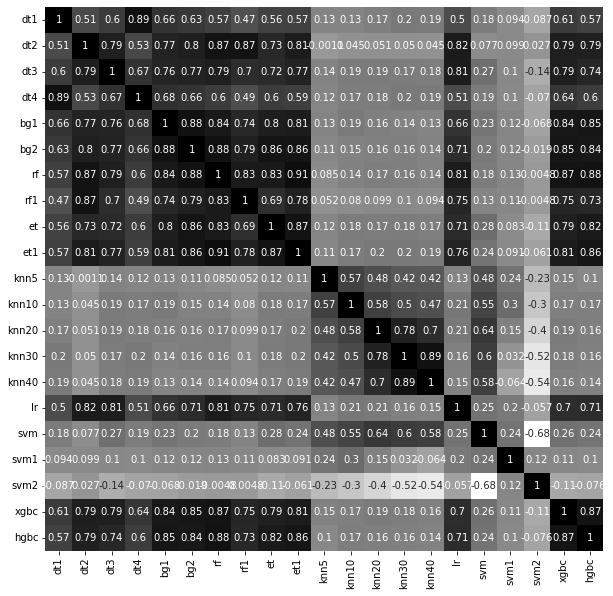

In [77]:
plt.figure(figsize=(10,10))
sns.heatmap(result_df.corr(),annot=True, cbar=False, cmap='binary')
plt.show()

In [78]:
clfs = [('dt1', dt_clf1), ('dt2', dt_clf2), ('dt3', dt_clf3), ('dt4', dt_clf4),
        ('bg', bg_clf), ('bg1', bg_clf1), 
        ('rf', rf_clf), ('rf1', rf_clf1), 
        ('et', et_clf), ('et1', et_clf1),
        ('knn5', knn_clf_5), ('knn10', knn_clf_10), ('knn20', knn_clf_20),
        ('knn30', knn_clf_30), ('knn40', knn_clf_40),
        ('lr', lr_clf),
        ('svm', svm_clf), ('svm1', svm_clf1), ('svm2', svm_clf2),
       ('xgbc',xgbcn),('hgbc',hgbcn)]

In [79]:
vo_clf  = VotingClassifier(estimators=clfs, voting='soft')
vo_clf.fit(X_train, y_train)
vo_clf.score(X_val, y_val)

[11:30:08] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:30:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8888888888888888

In [80]:
vo_clf.fit(X, y)
pred_vo = vo_clf.predict(df_kg)
tit = pd.read_csv('test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True) 
tit['Survived'] = pred_vo
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test(vo).csv')

[11:31:49] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:31:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [81]:
clfs = [('bg', bg_clf), ('bg1', bg_clf1), 
        ('rf', rf_clf), ('rf1', rf_clf1), 
        ('et', et_clf), ('et1', et_clf1),
        ('hgbc',hgbcn)]

In [82]:
vo_clf  = VotingClassifier(estimators=clfs, voting='soft')
vo_clf.fit(X_train, y_train)
vo_clf.score(X_val, y_val)

0.8777777777777778

In [83]:
vo_clf.fit(X, y)
pred_vo = vo_clf.predict(df_kg)
tit = pd.read_csv('test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True) 
tit['Survived'] = pred_vo
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test(vb).csv')

In [84]:
pip install imblearn

     |████████████████████████████████| 199 kB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 69.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [87]:
!pip install scikit-learn --user --upgrade

In [8]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
          random_state=19,
          k_neighbors=5,
          n_jobs=4)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
print('After Oversampling, the shape of tain_X : {}'.format(X_resampled.shape))
print('After Oversampling, the shape of tain_y : {}'.format(y_resampled.shape))

After Oversampling, the shape of tain_X : (980, 9)
After Oversampling, the shape of tain_y : (980,)


In [39]:
dt = DecisionTreeClassifier()
dt.fit(X_resampled, y_resampled)
pred_dt = dt.predict(X_val)
accuracy_score(y_val, pred_dt)

0.8111111111111111

In [40]:
dt2 = DecisionTreeClassifier()
dt2.fit(X_train, y_train)
pred_dt2 = dt.predict(X_val)
accuracy_score(y_val, pred_dt)

0.8111111111111111

In [12]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
pred_rf = rf.predict(X_val)
accuracy_score(y_val, pred_rf)

0.8555555555555555

In [13]:
et = ExtraTreesClassifier()
et.fit(X_resampled, y_resampled)
pred_et = et.predict(X_val)
accuracy_score(y_val, pred_et)

0.8555555555555555

In [15]:
bg = BaggingClassifier()
bg.fit(X_resampled, y_resampled)
pred_bg = bg.predict(X_val)
accuracy_score(y_val, pred_bg)

0.8666666666666667

In [41]:
print(metrics.classification_report(y_val,dt2.predict(X_val)))
print('-'*60)
print(metrics.classification_report(y_val,dt.predict(X_val)))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87        59
           1       0.77      0.74      0.75        31

    accuracy                           0.83        90
   macro avg       0.82      0.81      0.81        90
weighted avg       0.83      0.83      0.83        90

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        59
           1       0.73      0.71      0.72        31

    accuracy                           0.81        90
   macro avg       0.79      0.79      0.79        90
weighted avg       0.81      0.81      0.81        90



In [76]:
et1 = ExtraTreesClassifier(ccp_alpha=0.2, criterion='log_loss', max_depth=7,
                     max_features=None, min_samples_leaf=3, min_samples_split=8,
                     n_estimators=300, warm_start='False')
et1.fit(X_train, y_train)
pred_et = et1.predict(X_val)

bg1 = BaggingClassifier(max_samples=0.4, n_estimators=220, n_jobs=19, random_state=0,
                  verbose=3, warm_start='False')
bg1.fit(X_train, y_train)
pred_bg = bg1.predict(X_val)

rf1 = RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=7, warm_start='True')
rf1.fit(X_train, y_train)
pred_rf = rf1.predict(X_val)

from xgboost import XGBClassifier
xgb = XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_val)

dt = DecisionTreeClassifier()
dt.fit(X_resampled, y_resampled)
pred_dt = dt.predict(X_val)


from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.01,
                               loss='auto', max_depth=4, max_iter=400,
                               min_samples_leaf=12, n_iter_no_change=20,
                               warm_start='False')
hgb.fit(X_train, y_train)
pred_hgb = hgb.predict(X_val)

[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    2.8s remaining:   15.1s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    2.9s remaining:    2.6s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    3.1s finished
[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    0.0s finished


[16:10:46] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:10:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
stack = pd.DataFrame([pred_bg, pred_et, pred_hgb, pred_rf, pred_xgb, y_val]).T

In [78]:
stack.rename({0:'bag', 1:'ext', 2:'hgb', 3:'rf', 4:'xgb', 5:'y_val'},axis=1, inplace=True)

In [79]:
pd.set_option('display.max_rows', 1000)

In [81]:
stack

,bag,ext,hgb,rf,xgb,y_val
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,1
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,1,1,1
7,0,1,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn import metrics

In [ ]:
GridSearchCV()

In [139]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def kn_objective(search_space):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'n_neighbors':hp.choice('n_neighbors', range(2,10)),
              'leaf_size':hp.choice('leaf_size', range(10,100,10)),
              'p':hp.choice('p', range(1, 10)),
              'n_jobs':hp.choice('n_jobs', range(1,10))}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=kn_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|█████| 500/500 [00:04<00:00, 110.45trial/s, best loss: -0.7555555555555555]


In [140]:
best_params

{'leaf_size': 1, 'n_jobs': 3, 'n_neighbors': 3, 'p': 1}

In [141]:
best_kn_clf = KNeighborsClassifier(**params1)
best_kn_clf.fit(X_train, y_train)
best_kn_clf.score(X_val, y_val)

0.7555555555555555

In [143]:
best_kn_clf.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=20, n_jobs=4)

In [72]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def ex_objective(search_space):
    model = ExtraTreesClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'criterion':hp.choice('criterion', ['gini', 'entropy','log_loss']),
              'max_depth':hp.choice('max_depth', range(4,14)),
              'min_samples_split':hp.choice('min_samples_split', range(2, 10)),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 10)),
              'max_features':hp.choice('max_features', ["sqrt","log2",None]),
              'min_impurity_decrease':hp.choice('min_impurity_decrease', [0.0,0.2,0.4,0.6,0.8,1]),
              'ccp_alpha':hp.choice('ccp_alpha', [0.0,0.2,0.4,0.6,0.8,1]),
              'warm_start':hp.choice('warm_start', ['True', 'False']),
              'n_estimators':hp.choice('n_estimators', range(100,500,100))}



# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=ex_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|██████| 500/500 [01:17<00:00,  6.44trial/s, best loss: -0.8333333333333334]


In [73]:
best_params

{'ccp_alpha': 1,
 'criterion': 2,
 'max_depth': 3,
 'max_features': 2,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 2,
 'warm_start': 1}

In [74]:
best_ex_clf = ExtraTreesClassifier(**params1)
best_ex_clf.fit(X_train, y_train)
best_ex_clf.score(X_val, y_val)

0.8333333333333334

In [75]:
best_ex_clf.fit(X_train, y_train)

ExtraTreesClassifier(ccp_alpha=0.2, criterion='log_loss', max_depth=7,
                     max_features=None, min_samples_leaf=3, min_samples_split=8,
                     n_estimators=300, warm_start='False')

In [82]:
X_stack = stack.drop('y_val', axis=1)
y_stack = stack.y_val

In [83]:
dct = DecisionTreeClassifier()
dct.fit(X_stack, y_stack)
pred_stack = dct.predict(X_stack)
accuracy_score(y_val, pred_stack)

0.9333333333333333

In [84]:
rf1 = RandomForestClassifier()
rf1.fit(X_stack, y_stack)
pred_stack_rf1 = rf1.predict(X_stack)
accuracy_score(y_val, pred_stack_rf1)

0.9333333333333333

In [85]:
#테스트 예측

et1 = ExtraTreesClassifier(ccp_alpha=0.2, criterion='log_loss', max_depth=7,
                     max_features=None, min_samples_leaf=3, min_samples_split=8,
                     n_estimators=300, warm_start='False')
et1.fit(X, y)
pred_et1 = et1.predict(df_kg)

bg1 = BaggingClassifier(max_samples=0.4, n_estimators=220, n_jobs=19, random_state=0,
                  verbose=3, warm_start='False')
bg1.fit(X, y)
pred_bg1 = bg1.predict(df_kg)

rf1 = RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=7, warm_start='True')
rf1.fit(X, y)
pred_rf1 = rf1.predict(df_kg)

from xgboost import XGBClassifier
xgb = XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb.fit(X, y)
pred_xgb1 = xgb.predict(df_kg)



from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.01,
                               loss='auto', max_depth=4, max_iter=400,
                               min_samples_leaf=12, n_iter_no_change=20,
                               warm_start='False')
hgb.fit(X, y)
pred_hgb1 = hgb.predict(df_kg)

[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    2.8s remaining:   14.7s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    2.9s remaining:    2.6s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    3.1s finished
[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    0.0s finished


[16:38:31] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:38:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [115]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.01,
                               loss='auto', max_depth=4, max_iter=400,
                               min_samples_leaf=12, n_iter_no_change=20,
                               warm_start='False')
hgb.fit(X_train, y_train)
pred_hgb1 = hgb.predict(X)

In [116]:
rf1 = RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=7, warm_start='True')
rf1.fit(X_train, y_train)
pred_rf1 = rf1.predict(X)

In [117]:
et1 = ExtraTreesClassifier(ccp_alpha=0.2, criterion='log_loss', max_depth=7,
                     max_features=None, min_samples_leaf=3, min_samples_split=8,
                     n_estimators=300, warm_start='False')
et1.fit(X_train, y_train)
pred_et1 = et1.predict(X)

In [118]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb.fit(X_train, y_train)
pred_xgb1 = xgb.predict(X)

[16:55:30] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:55:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [119]:
bg1 = BaggingClassifier(max_samples=0.4, n_estimators=220, n_jobs=19, random_state=0,
                  verbose=3, warm_start='False')
bg1.fit(X_train, y_train)
pred_bg1 = bg1.predict(X)

[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    2.8s remaining:   15.0s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    2.9s remaining:    2.6s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    3.1s finished
[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    0.0s finished


In [125]:
et1 = ExtraTreesClassifier(ccp_alpha=0.2, criterion='log_loss', max_depth=7,
                     max_features=None, min_samples_leaf=3, min_samples_split=8,
                     n_estimators=300, warm_start='False')
et1.fit(X, y)
pred_et2 = et1.predict(df_kg)

In [126]:
bg1 = BaggingClassifier(max_samples=0.4, n_estimators=220, n_jobs=19, random_state=0,
                  verbose=3, warm_start='False')
bg1.fit(X, y)
pred_bg2 = bg1.predict(df_kg)

[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    2.6s remaining:   13.9s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    2.9s remaining:    2.6s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    2.9s remaining:    0.3s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    2.9s finished
[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   3 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  17 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:    0.0s finished


In [127]:
rf1 = RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=7, warm_start='True')
rf1.fit(X, y)
pred_rf2 = rf1.predict(df_kg)

In [128]:
from xgboost import XGBClassifier
xgb = XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0.7638002771865584,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, loss='exponential', max_delta_step=0,
              max_depth=8, max_features=None, min_child_weight=1,
              min_impurity_decrease=0.969767042752594, min_samples_leaf=20,
              min_samples_split=0.8119215852058577,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
xgb.fit(X, y)
pred_xgb2 = xgb.predict(df_kg)

[17:08:41] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:08:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [129]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.01,
                               loss='auto', max_depth=4, max_iter=400,
                               min_samples_leaf=12, n_iter_no_change=20,
                               warm_start='False')
hgb.fit(X, y)
pred_hgb2 = hgb.predict(df_kg)

In [120]:
stack1 = pd.DataFrame([np.array(pred_hgb1, int), 
                       np.array(pred_rf1, int), 
                       np.array(pred_et1, int), 
                       np.array(pred_xgb1, int), 
                       np.array(pred_bg1, int)]).T
stack1.rename({0:'hgb', 1:'rf', 2:'ex', 3:'xgb', 4:'bg'},axis=1, inplace=True)

In [131]:
stack_test = pd.DataFrame([np.array(pred_hgb2, int), 
                       np.array(pred_rf2, int), 
                       np.array(pred_et2, int), 
                       np.array(pred_xgb2, int), 
                       np.array(pred_bg2, int)]).T
stack1.rename({0:'hgb', 1:'rf', 2:'ex', 3:'xgb', 4:'bg'},axis=1, inplace=True)

In [121]:
stack1

,hgb,rf,ex,xgb,bg
0,0,0,0,0,0
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,1,1,1,0
9,1,1,1,1,1


In [136]:
stack_test

,0,1,2,3,4
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,1,1,1
5,0,0,0,0,0
6,1,1,1,1,1
7,0,1,0,1,0
8,1,1,1,1,1
9,0,0,0,0,0


In [132]:
rft = RandomForestClassifier()
rft.fit(stack1, y)
pred_stack_rft = rft.predict(stack_test)

(418,)

In [135]:
tit = pd.read_csv('test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True) 
tit['Survived'] = pred_stack_rft
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test(stack).csv')

Building estimator 1 of 12 for this parallel run (total 220)...
Building estimator 2 of 12 for this parallel run (total 220)...
Building estimator 3 of 12 for this parallel run (total 220)...
Building estimator 4 of 12 for this parallel run (total 220)...
Building estimator 5 of 12 for this parallel run (total 220)...
Building estimator 6 of 12 for this parallel run (total 220)...
Building estimator 7 of 12 for this parallel run (total 220)...
Building estimator 8 of 12 for this parallel run (total 220)...
Building estimator 9 of 12 for this parallel run (total 220)...
Building estimator 10 of 12 for this parallel run (total 220)...
Building estimator 11 of 12 for this parallel run (total 220)...
Building estimator 12 of 12 for this parallel run (total 220)...
Building estimator 1 of 12 for this parallel run (total 220)...
Building estimator 2 of 12 for this parallel run (total 220)...
Building estimator 3 of 12 for this parallel run (total 220)...
Building estimator 4 of 12 for this p

Building estimator 1 of 12 for this parallel run (total 220)...
Building estimator 2 of 12 for this parallel run (total 220)...
Building estimator 3 of 12 for this parallel run (total 220)...
Building estimator 4 of 12 for this parallel run (total 220)...
Building estimator 5 of 12 for this parallel run (total 220)...
Building estimator 6 of 12 for this parallel run (total 220)...
Building estimator 7 of 12 for this parallel run (total 220)...
Building estimator 8 of 12 for this parallel run (total 220)...
Building estimator 9 of 12 for this parallel run (total 220)...
Building estimator 10 of 12 for this parallel run (total 220)...
Building estimator 11 of 12 for this parallel run (total 220)...
Building estimator 12 of 12 for this parallel run (total 220)...
Building estimator 1 of 11 for this parallel run (total 220)...
Building estimator 2 of 11 for this parallel run (total 220)...
Building estimator 3 of 11 for this parallel run (total 220)...
Building estimator 4 of 11 for this p